# Read ASTRAL PSL mean meteorology files
## me2: radiometer, sea snake, pressure
## me1: ORG, 

In [1]:
# usings
using Revise
using Pkg; Pkg.activate(".")
using Dates
using Interpolations
using Printf
using PyPlot

# general PSL DAS readers
include("./readers.jl")
using .NoaaDas
using .DasFps

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
baseyear=2024

2024

In [3]:
# utilities
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# interpolators
"convert DateTime to a Number (milliseconds) delta relative to offset"
itime(dt, offst=DateTime(2024,4,1)) = Dates.value(dt - offst)

"linear interpolation function with DateTime coordinate"
function interpit(dt::AbstractVector{DateTime}, x::AbstractVector{<:Number})
    itp_core = interpolate( (itime.(dt),), x, Gridded(Linear()) )
    itp(dt) = itp_core( itime(dt) )
    return itp
end

interpit

In [4]:
#=
module DasFps

using ../NoaaDas

export read_fps_dict

baseyear = 2024

"read das data and put in a dictionary"
function read_fps_dict(pathfilename, keys;
    nheader=1,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_fps_data(pathfilename; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return NoaaDas.das_dict(keys, datatime, X) # returns dict
end

"read and parse one file"
function read_fps_data(pathfilename::AbstractString;
    nheader=1, 
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=26 )

    # trivially iterate over 1-vector
    dt, X = read_fps_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and concatenate data from multiple files"
function read_fps_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) .- nheader ),
    ncolumn=1 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s\*]+") # as many delims as possible, counting literal *

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = parseblank2missing.(Float32, splt[2:end])
                    maxcol = max(maxcol, nx) # data in longest line

                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end
=#

In [5]:
# read and plot an example day

mastdir = "./data/PSL/"
# keys for fps format
keys = [:time, :press]
dt = Date(2024,5,24) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# pathfilenames = get_das_pathfiles(prefix, dt)
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
Fp0 = read_fps_dict(get_das_pathfiles("fps0", dt), keys; ncolumn=1)
Fp2 = read_fps_dict(get_das_pathfiles("fps2", dt), keys; ncolumn=1)

Dict{Symbol, Any} with 2 entries:
  :press => Union{Missing, Float32}[997.9, 997.915, 997.927, 997.9, 997.948, 99…
  :time  => [DateTime("2024-05-24T00:00:00.099"), DateTime("2024-05-24T00:00:00…

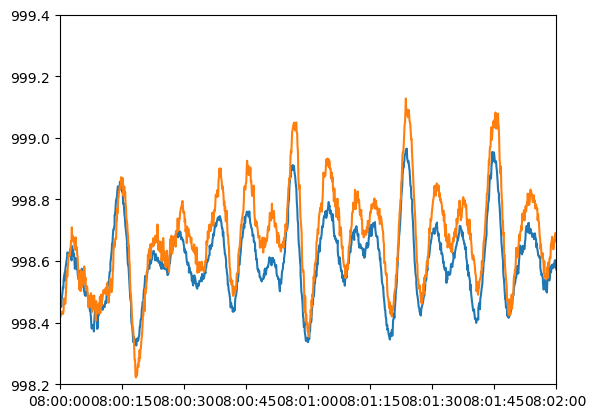

(998.2, 999.4)

In [14]:
"Substitutes NaN where f(x) evaluates to True."
nanfilt(f,x) = f(x) ? NaN : x 

# itpfp0 = interpolate(Fp0[:time], collect(nanfilt.(x->x>10_000, Fp0[:press])), Gridded(Linear()))
clf()
plot(Fp0[:time], Fp0[:press])
plot(Fp2[:time], Fp2[:press].-0.2)
xlim([DateTime(2024,5,24,8,0,0), DateTime(2024,5,24,8,02,0)])
ylim([998.2, 999.4])

In [12]:
size(Fp0[:press]), size(Fp2[:press])

((864001,), (864000,))